## AI Search Performance 

### The Search Engine

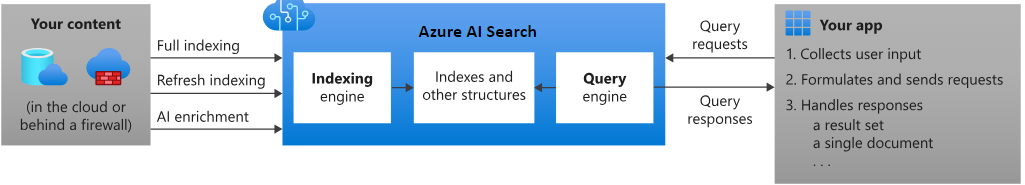

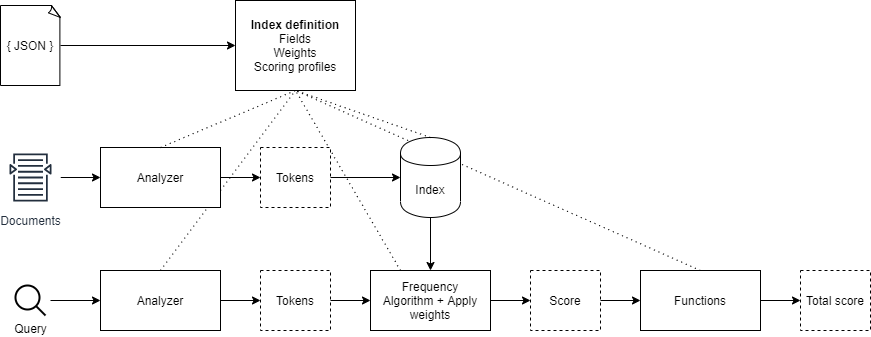

### Analyzers

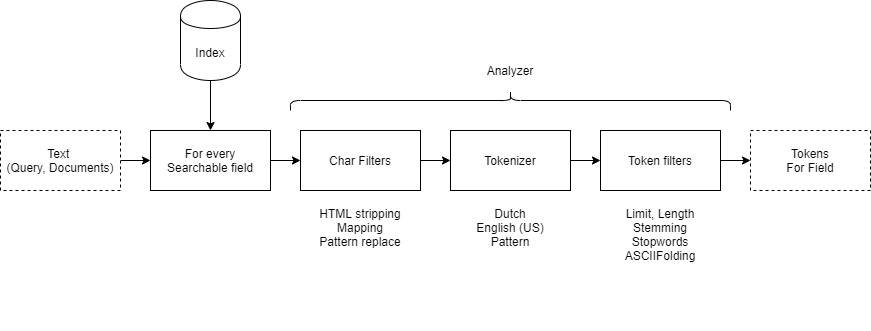

##### What's the usage of the analyzers

It’s important to know how an analyzer works. The tokens that are generated for every searchable field form the basis for every search outcome. One can easily test what tokens are generated by performing a simple REST call to the Azure Cognitive Search service. Below is an example of the differences between a standard (default) analyzer and the English en.microsoft analyzer. When submitting the text cycling helmet, the en.microsoft analyzer adds the stem of the word cycling, cycle. When the en.microsoft analyzer is configured as search analyzer, all properties that have the word cycle present in the index will be returned as a match for the given search query. This can be the cause of lots of noise or poorly matching search results.


#####  Demo - English Language Analyzer (Generate Tokens)

### Search Queries

##### How Scoring works

Now that you know how tokens are generated for both documents and search terms, let’s dive into the Azure Cognitive Search scoring mechanism. Based on the API version being used, Azure Cognitive Search uses either the BM25 or TFIDF algorithm. In principle, both algorithms come down to the same thing. Basically, what the algorithms do is compare the list of tokens stored in the index with the tokens generated for the specified search query and calculate a term frequency. The score that is calculated has a range of 0...1, where no results will be produced with a score of 0, but everything above is considered a result. So you can imagine that the conjugations the analyzer adds to the tokens can cause more documents to return a score of >0, which could cause your search results to be noisy. Obviously, the documents with the most matched terms will score the highest, and as a result will be considered the best search result


##### Demo - Different Type Of Search Queries 

### Azure AI Search Scaling Factors


##### Concepts: search units, replicas, partitions, shards

Capacity is expressed in search units that can be allocated in combinations of partitions and replicas, using an underlying sharding mechanism to support flexible configurations:

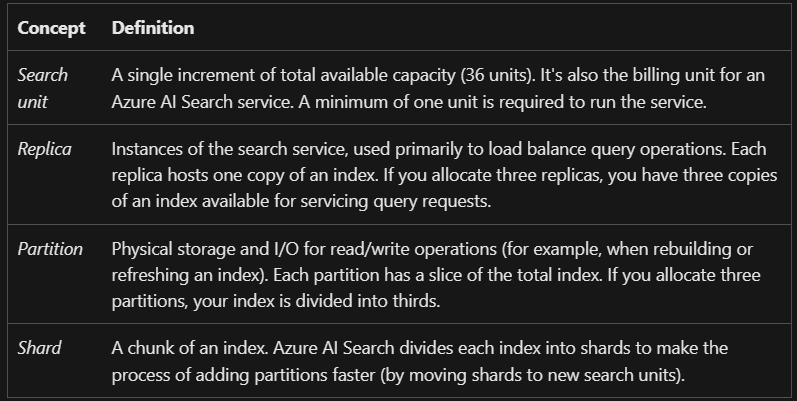


The following diagram shows the relationship between replicas, partitions, shards, and search units.

It shows an example of how a single index is spanned across four search units in a service with two replicas and two partitions. Each of the four search units stores only half of the shards of the index.

The search units in the left column store the first half of the shards, comprising the first partition, while those in the right column store the second half of the shards, comprising the second partition. 

Since there are two replicas, there are two copies of each index shard. The search units in the top row store one copy, comprising the first replica, while those in the bottom row store another copy, comprising the second replica.


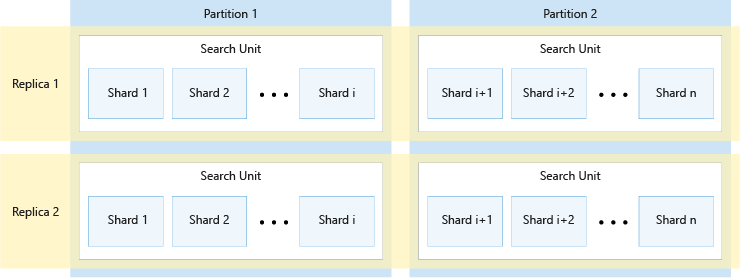


**Note**
 > In Azure AI Search, shard management is an implementation detail and non-configurable

##### Tips for capacity planning

Allow metrics to build around queries, and collect data around usage patterns (queries during business hours, indexing during off-peak hours). Use this data to inform service provisioning decisions. Though it's not practical at an hourly or daily cadence, you can dynamically adjust partitions and resources to accommodate planned changes in query volumes. You can also accommodate unplanned but sustained changes if levels hold long enough to warrant taking action.

**Note**
> Remember that the only downside of under provisioning is that you might have to tear down a service if actual requirements are greater than your predictions. To avoid service disruption, you would create a new service at a higher tier and run it side by side until all apps and requests target the new endpoint.

##### Demo - Open Azure AI Search Instance
https://portal.azure.com/#@fdpo.onmicrosoft.com/resource/subscriptions/477f20d6-672e-4530-a078-27d393a9eb98/resourceGroups/playground/providers/Microsoft.Search/searchServices/perf-test/scale

##### Service Limits

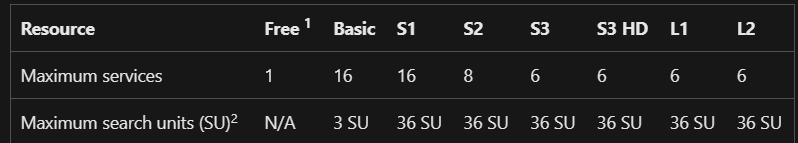

- You can have one free search service per Azure subscription. The free tier is based on infrastructure shared with other customers. Because the hardware isn't dedicated, scale-up isn't supported, and storage is limited to 50 MB.

- Search units (SU) are billing units, allocated as either a replica or a partition. You need both. To learn more about SU combinations, see Estimate and manage capacity of a search service.

Service Limits vary by the creation date


**Before April 3, 2024**

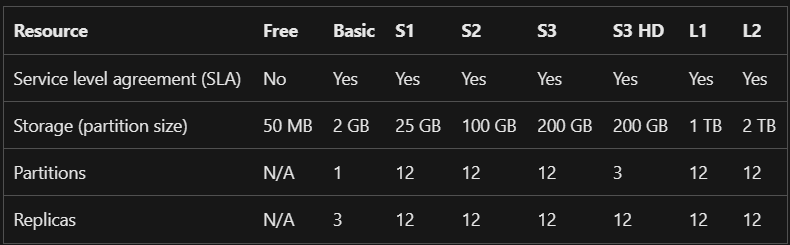

**After April 3, 2024**

For new services created after April 3, 2024:

Basic tier can have up to three partitions and three replicas, and a total of nine search units (SU).
Basic, S1, S2, S3 have more storage per partition, ranging from 3-7 times more, depending on the tier.
Your new search service must be in a supported region to get the extra capacity for Basic and other tiers.

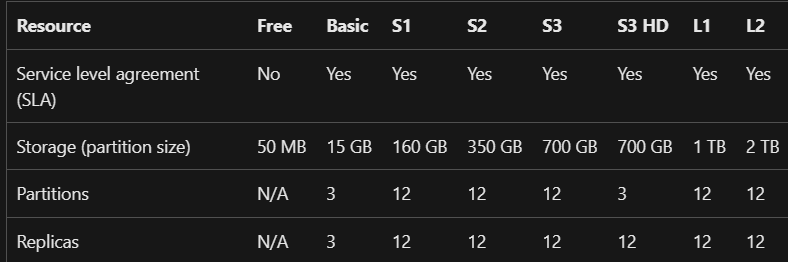

**Note**
> Currently, there's no in-place upgrade. You should create a new search service to benefit from the extra storage.

For other limits (Vector, # indexes or which tier support VPN ) https://learn.microsoft.com/en-us/azure/search/search-limits-quotas-capacity#vector-limits-on-services-created-after-april-3-2024-in-supported-regions

##### Partition and replica combinations

All Standard and Storage Optimized search services can assume the following combinations of replicas and partitions, subject to the 36-SU limit allowed for these tiers

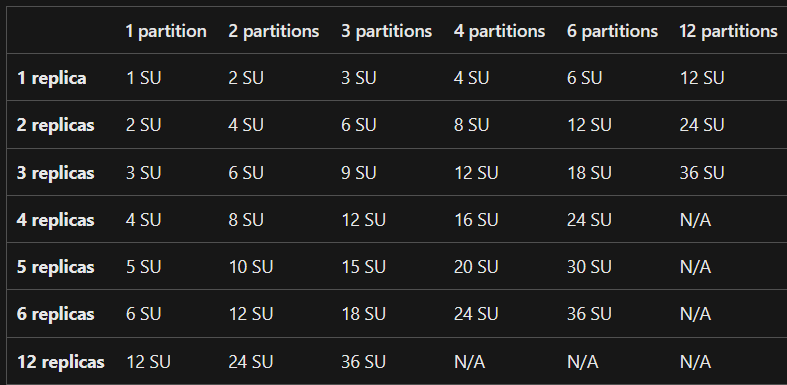

**Note**
> The number of replicas and partitions divides evenly into 12 (specifically, 1, 2, 3, 4, 6, 12). Azure AI Search pre-divides each index into 12 shards so that it can be spread in equal portions across all partitions. For example, if your service has three partitions and you create an index, each partition will contain four shards of the index. How Azure AI Search shards an index is an implementation detail, subject to change in future releases. Although the number is 12 today, you shouldn't expect that number to always be 12 in the future.


##### Pricing

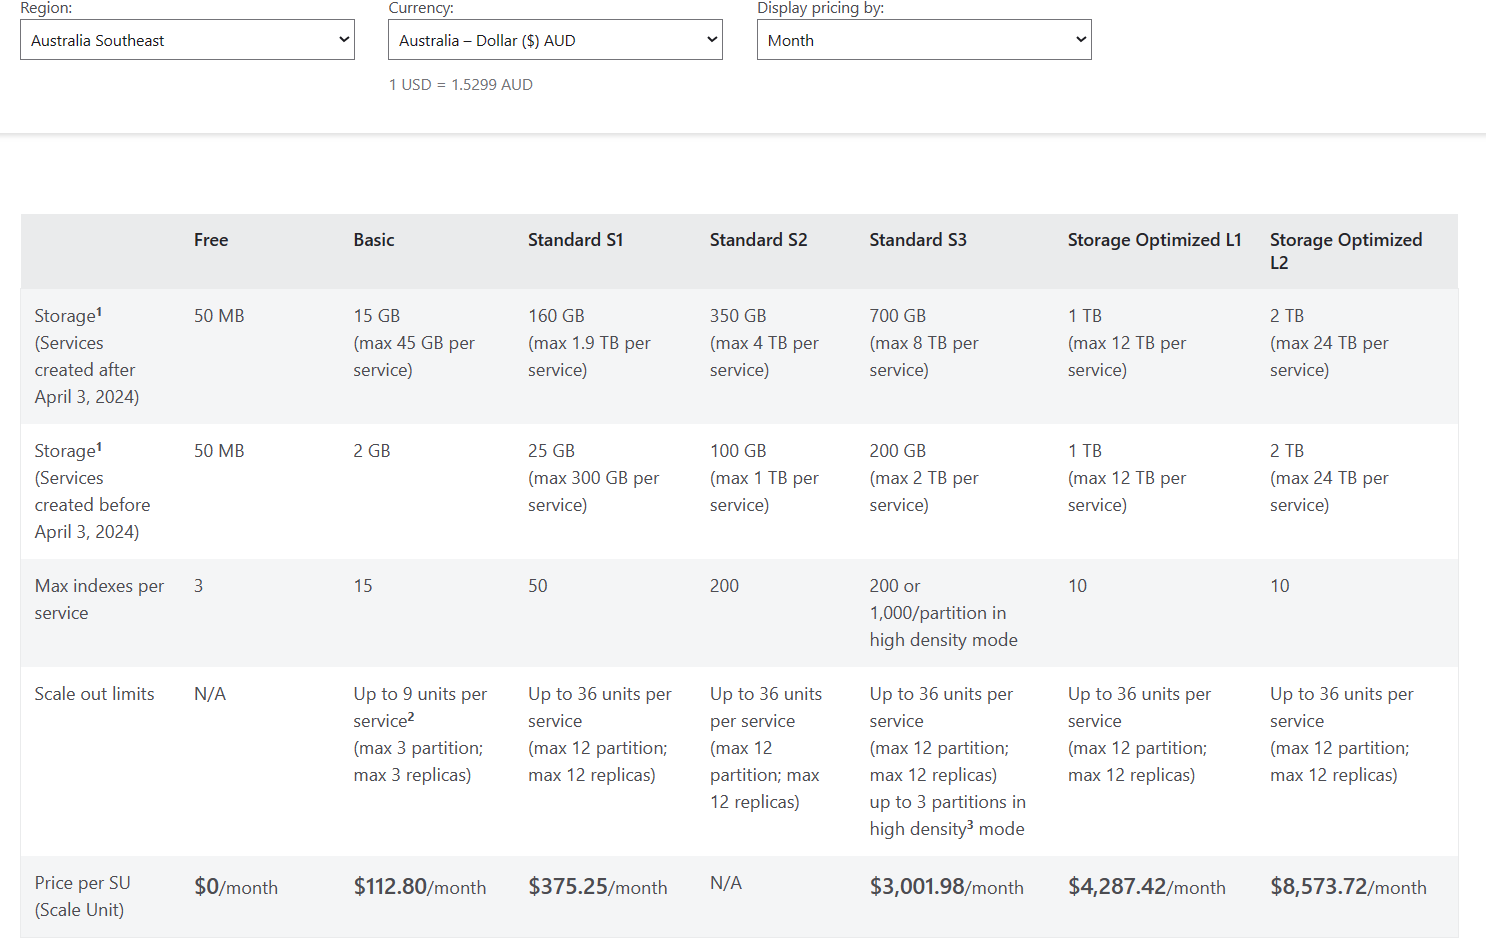

https://azure.microsoft.com/en-us/pricing/details/search/


**Note**
> Add a partition or move to a higher service tier.  You may be getting all the performance you can out of your service and configured and may want to consider scaling up.  Adding a partition will improve query performance slightly since your data is now divided among more search units and adds more computing power to your service.  Each search unit in higher tiers has more processing power and, as a result, individual queries may consistently perform better.


##### Performance Issues

**If the query sometimes is slow**
 > *Scenario 1*: 
 > When there is a spike in request volume at the search service level, either indexing or query, it is expected that latency can also increase.  In many cases, the recommendation here would be to accept a delay on updates to make more room for search queries, since an actual end-user is usually waiting for a search result and indexing operations are typically asynchronous.

 > *Scenario 2*:
 > When the number of requests is too high for the current configuration of the service, additional requests may be throttled. Queries become slow for a short period of time around the time the service was throttling requests.  Suggest assessing the acceptable percentage of throttled requests and add replicas to handle more traffic once that acceptable threshold is exceeded.


**If the query is always slow:**

> *Scenario1:* Query response size is too big. Suggest reducing the overall size of the response will also reduce the amount of time it takes to send the response over the network.  Some tactics for reducing response size:
- Reduce the number of fields retrieved.  Especially if a field is not displayed in the search UI.
- For large string fields, only retrieve hit highlights and not the full contents of the field.  It may not be needed for the UI.
- Keep the number of documents retrieved as small as possible.  Default is 5 but avoid going much higher than that.  

> *Scenario 2:* The filter criteria for each query are too complex, we should simplify the filter criteria for each query. 

> *Scenario3:* The number of searchable fields that are enabled on the index or targeted for a search query.  Reduce it can improve performance particularly at a high volume of data in the index, by reducing the amount of content in the index at search time

### Monitoring and Performance


##### Enable diagnostics

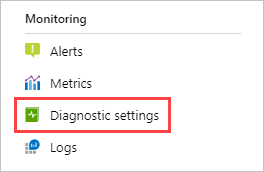

https://learn.microsoft.com/en-us/azure/azure-monitor/essentials/create-diagnostic-settings?tabs=portal


##### Analyzing service behavior

- Return a list of metrics and the associated aggregation. The query is scoped to the current search service over the time range that you specify.

    ```yaml
    AzureMetrics
    | project MetricName, Total, Count, Maximum, Minimum, Average
    ```
- List operations by name
  ```yaml 
  AzureDiagnostics
    | summarize count() by OperationName 
  ```
- Return queries entered by users
  ```yaml
    AzureDiagnostics
    | project OperationName, Query_s, IndexName_s, Documents_d
    | where OperationName == "Query.Search"
    | where Query_s != "?api-version=2023-07-01-preview&search=*" // ignoring find all for minimizing the noise
    | where IndexName_s == "realestate-us-sample-index" // specify the index
  ```
- Identify Http response breakdown
  ```yaml
    AzureDiagnostics
    | where TimeGenerated > ago(7d)
    | summarize count() by resultSignature_d 
    | render barchart 
  ```
- Long-running queries
  ```yaml
  AzureDiagnostics
    | project OperationName, resultSignature_d, DurationMs, Query_s, Documents_d, IndexName_s
    | where OperationName == "Query.Search"
    | sort by DurationMs
  ```
- Identify throttling over period of time
  ```yaml
  let intervalsize = 1m; 
  AzureDiagnostics 
    | where TimeGenerated > ago(3d)
    | where resultSignature_d != 403 and resultSignature_d != 404 and OperationName in ("Query.Search", "Query.Suggest", "Query.Lookup", "Query.Autocomplete")
    | summarize 
      ThrottledQueriesPerMinute=bin(countif(OperationName in ("Query.Search", "Query.Suggest", "Query.Lookup", "Query.Autocomplete") and resultSignature_d == 503)/(intervalsize/1m), 0.01)
      by bin(TimeGenerated, intervalsize)
    | render timechart   
  ``` 

### Performance Tips

https://learn.microsoft.com/en-us/azure/search/search-performance-tips


### Appendix


- https://learn.microsoft.com/en-AU/azure/search/search-what-is-azure-search
- https://learn.microsoft.com/en-us/azure/search/search-capacity-planning#concepts-search-units-replicas-partitions-shards
- https://dibranmulder.github.io/2020/09/22/Improving-your-Azure-Search-performance/
- https://learn.microsoft.com/en-us/azure/search/index-add-custom-analyzers
- https://techcommunity.microsoft.com/t5/azure-paas-blog/troubleshoot-azure-cognitive-search-latency-issue/ba-p/2668211
- https://dibranmulder.github.io/2020/09/22/Improving-your-Azure-Search-performance/